In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import scipy as sp
import json
import os
import math

import matplotlib
from matplotlib import pyplot as plt
plt.style.use('ggplot')

#from mpl_toolkits.basemap import Basemap, cm
from matplotlib.path import Path

from datetime import datetime
from dateutil import tz
import time
import datetime
import calendar


from stravalib.client import Client
from stravalib import unithelper

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)


# MAKE LIBRARY

### The Plan

| Month    | Days | Yardage |    Yds/Day   |  Yds/Week |  max hrs  |
| :------- |:---: | :-----: | :----------: | :-------: | :-------: |
| November | 30   |  80000  | 2,857.14285  |   20000   |    7.6    |
| December | 31   | 125000  | 4032.258065  |   25000   |    7.6    |
| January  | 31   | 125000  | 4032.258065  |   28000   |    7.6    |
| February | 28   | 130000  | 4642.857143  |   32500   |    9.8    |
| March    | 31   | 140000  | 4516.129032  |   31615   |   10.6    |
| April    | 31   | 140000  | 4516.129032  |   31615   |   10.6    |
| May      | 31   | 140000  | 4516.129032  |   31615   |    8.5    |
| June     | 30   | 150000  | 5000         |   35000   |   11.4    |

Shots?

In [4]:
m_to_yd = 1.09361
m_to_miles = 1609.34

catalina_yd = 35323.71


#one_square = 380.22 #* m_to_yd


json_data=open('{0}/strava_credentials.json'.format(os.getenv("HOME"))).read()
credentials = json.loads(json_data)
client = Client(access_token=credentials['AccessToken'])

In [5]:
activities = client.get_activities(after='2017-11-01', before='2018-09-05')

my_swims = pd.DataFrame([{'name':activity.name, 
                          'id': activity.id, 
                          'stroke_count': 2 * activity.average_cadence if activity.average_cadence is not None else None,
                          'average_speed':float(unithelper.meters_per_second(activity.average_speed)),
                          'elapsed_time':unithelper.timedelta_to_seconds(activity.elapsed_time), 'start_date': activity.start_date,
                          'distance':float(unithelper.meters(activity.distance)) * m_to_yd} for activity in activities if activity.type=='Swim'])
my_swims = my_swims.set_index('start_date')
my_swims.index = pd.DatetimeIndex(my_swims.index)
my_swims.index = my_swims.index.tz_convert('US/Pacific')
my_swims['month'] = my_swims.index.month
my_swims['month_name'] = my_swims['month'].apply(lambda x: calendar.month_abbr[x])
my_swims['ds_week_ending'] = my_swims.index.to_period('W').end_time
my_swims['is_pool'] = ['pool' if "[POOL]" in name else 'open water' for name in my_swims.name]

No handlers could be found for logger "stravalib.model.Activity"


In [6]:
my_swims.groupby(['is_pool'])['distance'].sum()

is_pool
open water    39638.331894
pool           7392.147434
Name: distance, dtype: float64

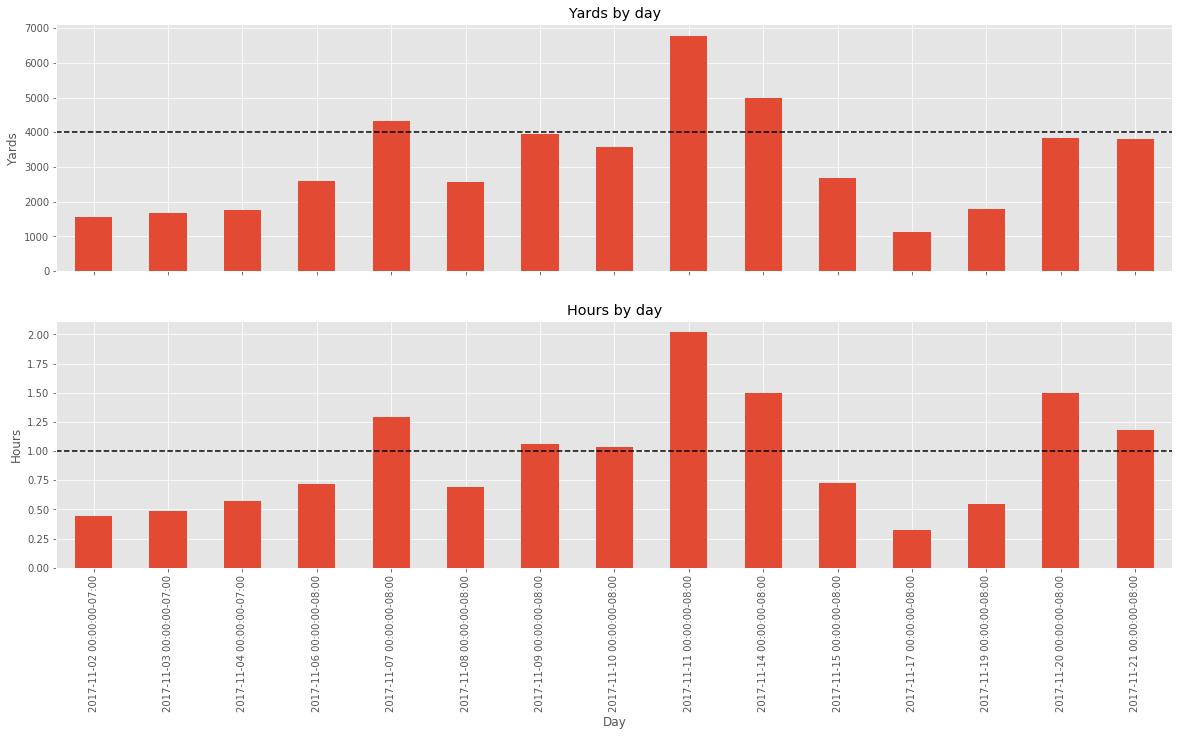

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].set_title('Yards by day')
axes[1].set_title('Hours by day')


my_swims.groupby(my_swims.index.normalize()).distance.sum().plot(kind='bar', ax=axes[0], sharex=True)
axes[0].axhline(4000, color='k', linestyle='--')
axes[0].set_ylabel('Yards')
#axes[0].step([-1, max(np.where(my_swims.index.normalize().unique().month <= 1)[0])-0.5, 100.5], [0, 3000 / m_to_yd, 4000 / m_to_yd], color='k', linestyle='--')



my_swims.groupby(my_swims.index.normalize()).elapsed_time.sum().apply(lambda x: x / 3600).plot(kind='bar', ax=axes[1])
axes[1].set_ylabel('Hours')
axes[1].set_xlabel('Day')
axes[1].axhline(1, color='k', linestyle='--')
#axes[1].step([-1, max(np.where(my_swims.index.normalize().unique().month <= 1)[0])-0.5, 100.5], [0, 1, 2], color='k', linestyle='--')


Text(0.5,0,u'Week')

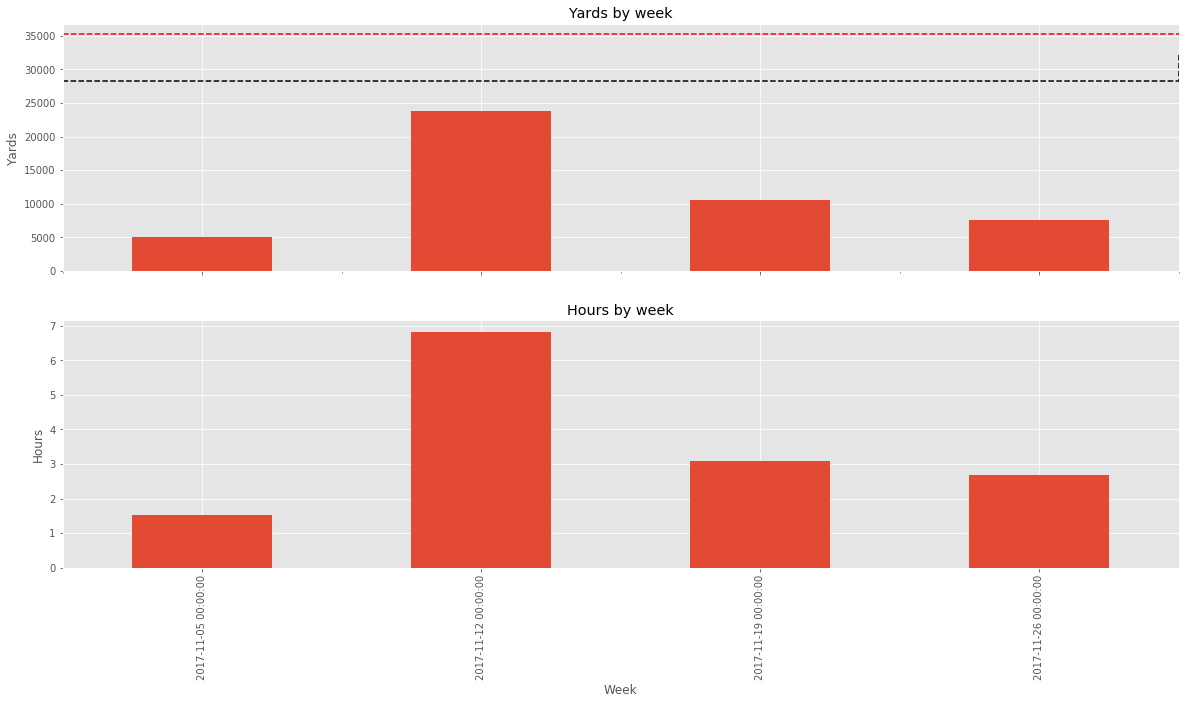

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].set_title('Yards by week')
axes[1].set_title('Hours by week')


my_swims.groupby(my_swims.ds_week_ending).distance.sum().plot(kind='bar', ax=axes[0], sharex=True)
#axes[0].axhline(28000 / m_to_yd, color='k', linestyle='--')
axes[0].set_ylabel('Yards')
axes[0].step([-1, 3.5, 7.5, 12.5, 16.5, 20.5, 24.5, 28.5, 36.5], 
             [0, 28225, 32500, 31615, 31615, 31615, 35000, 33870, 33870], color='k', linestyle='--')
axes[0].axhline(catalina_yd, color='r', linestyle='--')


my_swims.groupby(my_swims.ds_week_ending).elapsed_time.sum().apply(lambda x: x / 3600).plot(kind='bar', ax=axes[1])
#axes[1].axhline(7.6, color='k', linestyle='--')
axes[1].set_ylabel('Hours')
axes[1].set_xlabel('Week')


Text(0.5,0,u'Week')

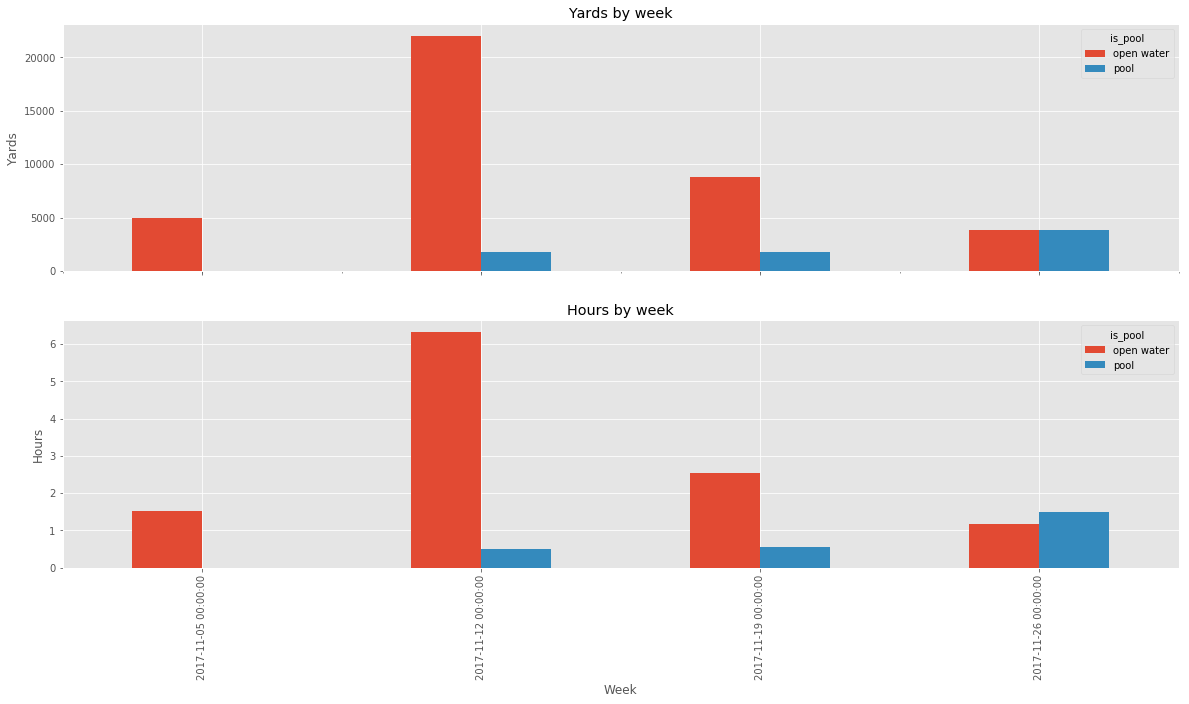

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].set_title('Yards by week')
axes[1].set_title('Hours by week')

my_swims.groupby(['ds_week_ending', 'is_pool'])['distance'].sum().unstack().plot(kind='bar', ax=axes[0], sharex=True)
#axes[0].axhline(28000 / m_to_yd, color='k', linestyle='--')
axes[0].set_ylabel('Yards')
#axes[0].step([-1, 3.5, 7.5], [0, 28000 / m_to_yd, 32000 / m_to_yd], color='k', linestyle='--')
#axes[0].axhline(catalina_yd, color='r', linestyle='--')

my_swims.groupby(['ds_week_ending', 'is_pool'])['elapsed_time'].sum().apply(lambda x: x / 3600).unstack().plot(kind='bar', ax=axes[1])
#axes[1].axhline(7.6, color='k', linestyle='--')
axes[1].set_ylabel('Hours')
axes[1].set_xlabel('Week')


Text(0.5,0,u'Month')

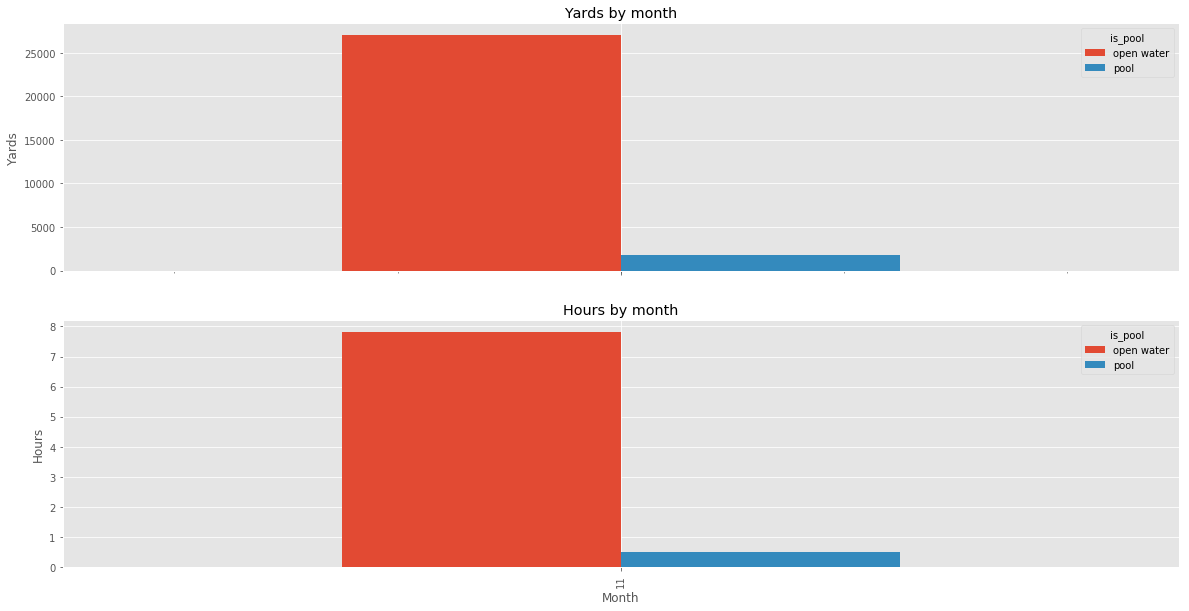

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].set_title('Yards by month')
axes[1].set_title('Hours by month')


my_swims.groupby(['month', 'is_pool'])['distance'].sum().unstack().plot(kind='bar', ax=axes[0], sharex=True)
#axes[0].axhline(28000 / m_to_yd, color='k', linestyle='--')
axes[0].set_ylabel('Yards')
#axes[0].step([-1, 3.5, 7.5], [0, 28000 / m_to_yd, 32000 / m_to_yd], color='k', linestyle='--')
#axes[0].axhline(catalina_yd, color='r', linestyle='--')

my_swims.groupby(['month', 'is_pool'])['elapsed_time'].sum().apply(lambda x: x / 3600).unstack().plot(kind='bar', ax=axes[1])
#axes[1].axhline(7.6, color='k', linestyle='--')
axes[1].set_ylabel('Hours')
axes[1].set_xlabel('Month')
